# Numeric Tic-Tac-Toe:
Rules of the Game:
* The game will be played on a 3x3 grid (9 cells) using numbers from 1 to 9. Each number can be used exactly once in the entire grid.
* There are two players: one is the Reinforcement Learning (RL) agent and other is the environment.
* The RL agent is given odd numbers {1, 3, 5, 7, 9} and the environment is given the even numbers {2, 4, 6, 8}.
* Each of them takes a turn. The player with odd numbers always goes first.
* At each round, a player puts one unused number on a blank spot.
* The objective is to make 15 points in a row, column or a diagonal. The player can use the opponent's numbers in the grid to make 15.
* The game terminates when any one of the players makes 15.

## Tic-Tac-Toe Agent

In this notebook file, we will build an RL agent that learns to play `Numerical Tic-Tac-Toe` with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. 
* we have modelled our `environment as MDP process`, since as per our problem statement, the current state of environment (i.e. current state of game board) is suffiecient for taking future actions.
* For given reinforecemnt learning task, we will use `Q-learning` for training our agent.

In [1]:
#### Importing TicTacToe class from enviroment liabrary:
from TCGame_Env1 import TicTacToe

In [2]:
#### Importing other useful liabraries
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [3]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [4]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state:
def valid_actions(state):
    valid_Actions = []
    valid_Actions = [i for i in env.action_space(state)[0]] 
    return valid_Actions

In [5]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    if state1 not in Q_dict.keys():
        valid_act = valid_actions(state)
        for action in valid_act:
            Q_dict[state1][action]= 0

#### We will use Epsilon-greedy strategy for generating optimal policy:
* In Epsilon-greedy strategy, we generate the random number between 0 and 1 and depending upon the value of Epsilon, we take corresponding action: if value generated is less than Epsilon we take random action. But if value generated is more than epsilon we take the most greedy/optimal action. This ensures exploration.
* Initially we want to explore more. But as we move towards the end of the RL training, we want to exploit the best policy. For this reason we will use dacying rate to achieve the balance between exploration and exploitation as there is a trade off between these two.

In [6]:
# Defining epsilon-greedy policy:
def epsilon_greedy(state, episode):
    max_epsilon = 1.0
    min_epsilon = 0.001
    decay_rate = 0.0000015
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)
    z = np.random.random()
        
    if z > epsilon:    #Exploitation:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get) #this gets the action corresponding to max q-value of current state
    else:               #Exploration:
        action = random.choice(valid_actions(state))    #randomly choosing an action.
    
    return action

#### Tracking the state-action pairs for checking convergence

In [7]:
# Initializing Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence) :
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

print(len(Q_dict))
print(len(States_track))

0
0


In [8]:
# Initializing states to be tracked:
def initialise_tracking_states():
    sample_q_values = [('x-x-x-x-x-x-x-x-x',(1,9)), ('x-x-x-x-x-x-3-4-x',(3, 5)),
                       ('x-x-x-x-x-x-x-9-8',(3, 3)),('x-x-x-x-x-x-x-1-4',(1, 5))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = []

In [9]:
# tracking updated values of 'States_track' to later check for convergence:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
initialise_tracking_states()

# we will be tracking following states:
States_track

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(1, 9): []},
             'x-x-x-x-x-x-3-4-x': {(3, 5): []},
             'x-x-x-x-x-x-x-9-8': {(3, 3): []},
             'x-x-x-x-x-x-x-1-4': {(1, 5): []}})

In [11]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#### Defining hyperparameters :
* Learning rate:
    * decides how much you want to update the existing value in accordance with the new value.
    * Very large Learning rate may result in unstable training where as very low value will take much longer training time
* Discount factor:
    * decides how much importance should be given to future rewards as the future is uncertain it's not always ideal to value your future rewards too much. It also helps to keep the reward bounded for continuous tasks.
    * High value means it will give higher importance to future rewards.

In [12]:
EPISODES = 7000000         #Number of training episodes
LR = 0.2                   #Learning rate
GAMMA = 0.8                #Discount factor

### Q-update loop ---write your code here

In [13]:
threshold = 1000           #every these many episodes, the 4 Q-values will be appended (states_tracked)
policy_threshold = 10000   #every these many episodes, the Q-dict will be saved
agent_won_counter = 0
env_won_counter = 0
draw_counter = 0


start_time = time.time()

for episode in range(EPISODES):
    env = TicTacToe()
    curr_state = env.state
    terminal_flag = False  
    add_to_dict(curr_state)
    total_reward = 0
    while terminal_flag != True:
        curr_state_str = Q_state(curr_state)
        action = epsilon_greedy(curr_state,episode)
        reward,next_state,terminal_flag,info = env.step(curr_state , action)
        add_to_dict(next_state)
        next_state_str = Q_state(next_state)
        if terminal_flag != True:
            max_next = max(Q_dict[next_state_str],key=Q_dict[next_state_str].get)
            Q_dict[curr_state_str][action] += LR * ((reward + (GAMMA*(Q_dict[next_state_str][max_next]))) - Q_dict[curr_state_str][action] )
        else :
            Q_dict[curr_state_str][action] += LR * (reward  - Q_dict[curr_state_str][action] )
        
        curr_state = next_state
        total_reward += 0
    
    if info == 'agent won':
        agent_won_counter += 1
    elif info == 'env won':
        env_won_counter += 1
    else:
        draw_counter += 1
    
    if (episode + 1) % (policy_threshold*70) == 0:
        print(f"After training for {episode + 1} episodes, Agent Won : {round(agent_won_counter/ (episode + 1)*100,2)}% of times, Environment Won : {round(env_won_counter/ (episode + 1)*100,2)} % of times and game tied : {round(draw_counter/ (episode + 1)*100,2)}% of times") 
    
    if ((episode+1) % threshold) == 0:   
        save_tracking_states()
        save_obj(States_track,'States_tracked')
        
    if ((episode+1)% policy_threshold ) == 0:  
        save_obj(Q_dict,'Policy')
    
    
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
print('Run time: ', elapsed_time)

After training for 700000 episodes, Agent Won : 36.67% of times, Environment Won : 24.07 % of times and game tied : 39.27% of times
After training for 1400000 episodes, Agent Won : 55.33% of times, Environment Won : 17.2 % of times and game tied : 27.47% of times
After training for 2100000 episodes, Agent Won : 66.99% of times, Environment Won : 12.65 % of times and game tied : 20.36% of times
After training for 2800000 episodes, Agent Won : 74.19% of times, Environment Won : 9.79 % of times and game tied : 16.02% of times
After training for 3500000 episodes, Agent Won : 78.88% of times, Environment Won : 7.92 % of times and game tied : 13.2% of times
After training for 4200000 episodes, Agent Won : 82.11% of times, Environment Won : 6.63 % of times and game tied : 11.26% of times
After training for 4900000 episodes, Agent Won : 84.46% of times, Environment Won : 5.7 % of times and game tied : 9.84% of times
After training for 5600000 episodes, Agent Won : 86.24% of times, Environment 

#### Checking the Q-dictionary:

In [14]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 1.8906245995450994,
              (0, 3): 0.3641253012773592,
              (0, 5): 2.8657499016707684,
              (0, 7): 0.9099722168993518,
              (0, 9): 1.2408826531232897,
              (1, 1): 1.3327248400960254,
              (1, 3): 2.328568728600315,
              (1, 5): 1.1852619293065152,
              (1, 7): 0.7677990510168534,
              (1, 9): 4.136230009966817,
              (2, 1): 2.521787975447141,
              (2, 3): 0.23696989242543853,
              (2, 5): 2.525017642343406,
              (2, 7): 0.5929542498972744,
              (2, 9): 2.3737553863699015,
              (3, 1): 0.7395055025133983,
              (3, 3): 2.4026073117539517,
              (3, 5): 1.1841669478242651,
              (3, 7): 1.3536937329580572,
              (3, 9): 0.9092730237168241,
              (4, 1): 0.9021304552422007,
              (4, 3): -0.5477204560886482,
              (4, 5): -0.16808675893098

In [15]:
len(Q_dict)

1303090

In [16]:
# checking for one of the states - that which action our agent thinks is the best:
# Lets consider the state : 5-x-x-x-x-x-1-2-8
# We can see best action is (3,9)
#   5 | x | x                          5 | x | x
#   ----------                         ----------
#   x | x | x          ======>         9 | x | x
#   ----------                         ----------
#   1 | 2 | 8                          1 | 2 | 8

# Lets confirm:
# After training is completed RL agent will take the most greedy/optimum action:
max(Q_dict['5-x-x-x-x-x-1-2-8'],key= lambda x: Q_dict['5-x-x-x-x-x-1-2-8'][x])

(1, 3)

#### Checking the states tracked for Q-values convergence:

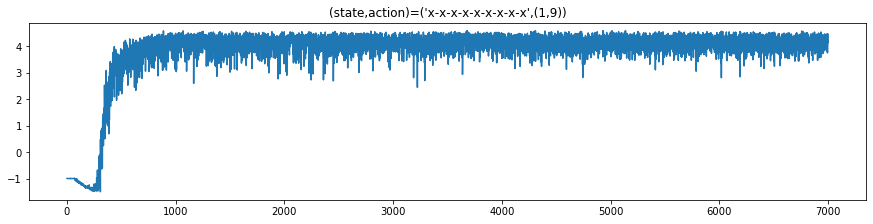

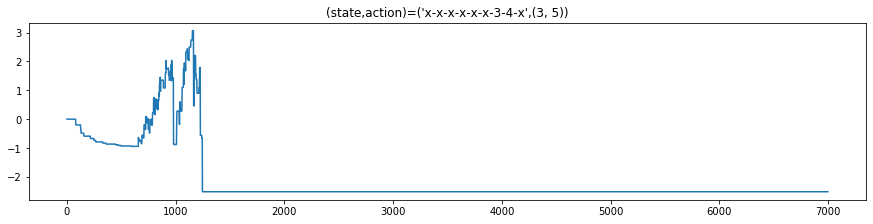

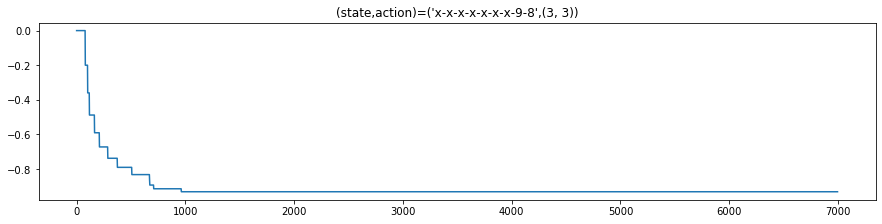

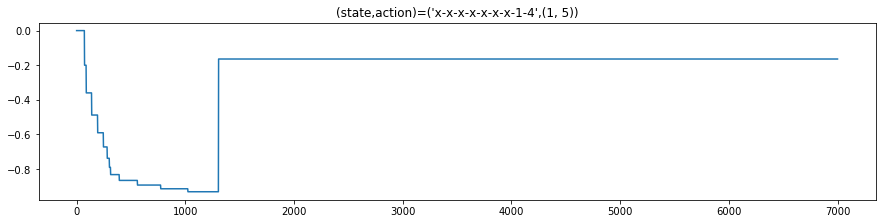

In [17]:
plt.figure(figsize=[15,15])
plt.subplot(4, 1, 1)
x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-x-x'][(1,9)])))
y_axis = States_track['x-x-x-x-x-x-x-x-x'][(1,9)]
plt.title("(state,action)=('x-x-x-x-x-x-x-x-x',(1,9))")
plt.plot(x_axis,y_axis)

plt.figure(figsize=[15,15])
plt.subplot(4, 1, 2)
x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-3-4-x'][(3, 5)])))
y_axis = States_track['x-x-x-x-x-x-3-4-x'][(3, 5)]
plt.title("(state,action)=('x-x-x-x-x-x-3-4-x',(3, 5))")
plt.plot(x_axis,y_axis)

plt.figure(figsize=[15,15])
plt.subplot(4, 1, 3)
x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-9-8'][(3, 3)])))
y_axis = States_track['x-x-x-x-x-x-x-9-8'][(3, 3)]
plt.title("(state,action)=('x-x-x-x-x-x-x-9-8',(3, 3))")
plt.plot(x_axis,y_axis)

plt.figure(figsize=[15,15])
plt.subplot(4, 1, 4)
x_axis = np.asarray(range(0, len(States_track['x-x-x-x-x-x-x-1-4'][(1, 5)])))
y_axis = States_track['x-x-x-x-x-x-x-1-4'][(1, 5)]
plt.title("(state,action)=('x-x-x-x-x-x-x-1-4',(1, 5))")
plt.plot(x_axis,y_axis)

plt.show()

We can see that as number of episodes increases, q value converges for tracked states.

### Epsilon - decay check

In [18]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,7000000)
epsilon = []
for i in range(0,7000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.0000015*i))

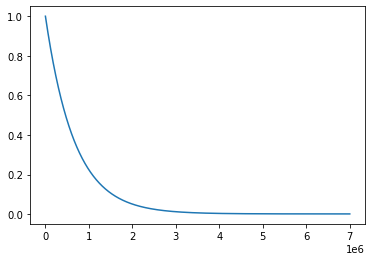

In [19]:
plt.plot(time, epsilon)
plt.show()